In [1]:
using OrdinaryDiffEq, SteadyStateDiffEq, ModelingToolkit, QuantumOptics
using Plots

In [2]:
include("../../src/indexing.jl")
include("../../src/doubleSums.jl")
include("../../src/averageSums.jl")
include("../../src/indexedMeanfield.jl")
include("../../src/indexedScale.jl")
include("../../src/indexedCorrelation.jl")

filterComplete_corr (generic function with 1 method)

In [3]:
M = 4 # order
@cnumbers N Δ g κ Γ R ν

# Hilbertspace
hc = FockSpace(:cavity)
ha_ = NLevelSpace(:atom,2)
ha = ClusterSpace(ha_, N, M)
h = hc ⊗ ha

ℋ(cavity) ⊗ Nxℋ(atom)

In [4]:
# operators
@qnumbers a::Destroy(h)
σ(i,j) = Transition(h, :σ, i, j)

σ (generic function with 1 method)

In [5]:
# Hamiltonian
H = -Δ*a'a + g*(a'*sum(σ(1,2)) + a*sum(σ(2,1)))

# Jump operators & rates
J = [a, σ(1,2), σ(2,1), σ(2,2)]
rates = [κ, Γ, R, ν]

4-element Vector{Sym{Parameter, Base.ImmutableDict{DataType, Any}}}:
 κ
 Γ
 R
 ν

In [6]:
# Derive equations
ops = [σ(2,2)[1]]
eqs = meanfield(ops,H,J;rates=rates,order=M)

∂ₜ(⟨σ_122⟩) = R + (0 + 1im)*g*⟨a′*σ_112⟩ + (0 - 1im)*g*⟨a*σ_121⟩ - R*⟨σ_122⟩ - Γ*⟨σ_122⟩


In [7]:
# custom filter function
φ(x::Average) = φ(x.arguments[1])
φ(::Destroy) = -1
φ(::Create) =1
φ(x::QTerm) = sum(map(φ, x.args_nc))
φ(x::Transition) = x.i - x.j
phase_invariant(x) = iszero(φ(x))

# Complete equations
eqs_c = complete(eqs; filter_func=phase_invariant)

∂ₜ(⟨σ_122⟩) = R + (0 + 1im)*g*⟨a′*σ_112⟩ + (0 - 1im)*g*⟨a*σ_121⟩ - R*⟨σ_122⟩ - Γ*⟨σ_122⟩
∂ₜ(⟨a′*σ_112⟩) = (0 + 1im)*g*⟨σ_122⟩ + (0 - 1im)*g*⟨a′*a⟩ + (0 + 2im)*g*⟨a′*a*σ_122⟩ + (0 - 1im)*Δ*⟨a′*σ_112⟩ + (0 + 3im)*g*((1//3)*N - (1//1))*⟨σ_121*σ_212⟩ - 0.5R*⟨a′*σ_112⟩ - 0.5Γ*⟨a′*σ_112⟩ - 0.5κ*⟨a′*σ_112⟩ - 0.5ν*⟨a′*σ_112⟩
∂ₜ(⟨a′*a⟩) = (0//1 - 1//1*im)*N*g*⟨a′*σ_112⟩ + (0//1 + 1//1*im)*N*g*⟨a*σ_121⟩ - κ*⟨a′*a⟩
∂ₜ(⟨a′*a*σ_122⟩) = R*⟨a′*a⟩ + (0 + 1im)*g*⟨a′*a′*a*σ_112⟩ + (0 - 1im)*g*⟨a′*a*a*σ_121⟩ + (0 - 3im)*g*((1//3)*N - (1//1))*⟨a′*σ_122*σ_212⟩ + (0 + 3im)*g*((1//3)*N - (1//1))*⟨a*σ_122*σ_221⟩ - R*⟨a′*a*σ_122⟩ - Γ*⟨a′*a*σ_122⟩ - κ*⟨a′*a*σ_122⟩
∂ₜ(⟨σ_121*σ_212⟩) = (0 + 1im)*g*⟨a′*σ_112⟩ + (0 - 1im)*g*⟨a*σ_121⟩ + (0 - 2im)*g*⟨a′*σ_122*σ_212⟩ + (0 + 2im)*g*⟨a*σ_122*σ_221⟩ - R*⟨σ_121*σ_212⟩ - Γ*⟨σ_121*σ_212⟩ - ν*⟨σ_121*σ_212⟩
∂ₜ(⟨a′*a′*a*σ_112⟩) = g*((0 + 2im)*⟨a′*a*σ_122⟩ + (0 - 8im)*(⟨a′*a⟩^2)*⟨σ_122⟩ + (0 + 8im)*⟨a′*a⟩*⟨a′*a*σ_122⟩ + (0 + 2im)*⟨σ_122⟩*⟨a′*a′*a*a⟩) + (0 - 1im)*g*⟨a′*a′*a*a⟩ +

In [8]:
@named sys = ODESystem(eqs_c)

Model sys with 18 equations
States (18):
  var"⟨σ_122⟩"(t)
  var"⟨a′*σ_112⟩"(t)
  var"⟨a′*a⟩"(t)
  var"⟨a′*a*σ_122⟩"(t)
  var"⟨σ_121*σ_212⟩"(t)
  var"⟨a′*a′*a*σ_112⟩"(t)
⋮
Parameters (7):
  g
  R
  Γ
  Δ
  ν
  κ
⋮

In [9]:
# Initial state
u0 = zeros(ComplexF64, length(eqs_c))
# System parameters

ps = [N, Δ, g, κ, Γ, R, ν]
p0 = [5e4, 0, 2e3, 5e6, 1, 2e3, 1e3]

prob = SteadyStateProblem(sys,u0,ps.=>p0);

In [10]:
sol = solve(prob,DynamicSS(Tsit5());reltol=1e-14,abstol=1e-14);

In [11]:
# Plot time evolution
#=
t = sol.t
n = real.(sol[a'a])
s22 = real.(sol[σ(2,2)[1]])

# Plot
p1 = plot(t, n, xlabel="tΓ", ylabel="⟨a⁺a⟩", legend=false)
p2 = plot(t, s22, xlabel="tΓ", ylabel="⟨σ22⟩", legend=false)
plot(p1, p2, layout=(1,2), size=(700,300))
=#

In [12]:
corr = CorrelationFunction(a', a, eqs_c; steady_state=true, filter_func=phase_invariant)
S = Spectrum(corr, ps)

ℱ(⟨a′*a_0⟩)(ω)

In [16]:
#prob_ss = SteadyStateProblem(prob)
#sol_ss = solve(prob_ss, DynamicSS(Tsit5(); abstol=1e-14, reltol=1e-14),
#    reltol=1e-14, abstol=1e-14, maxiters=5e7)

In [15]:
ω = [-25:0.001:25;]
spec = S(ω,sol.u,p0)
spec_n = spec ./ maximum(spec)
δ = abs(ω[(findmax(spec)[2])])

0.0

In [17]:
corr.de

∂ₜ(⟨a′*a_0⟩) = (0 - 1im)*Δ*⟨a′*a_0⟩ + (0//1 + 1//1*im)*N*g*⟨σ_121*a_0⟩ - 0.5κ*⟨a′*a_0⟩
∂ₜ(⟨σ_121*a_0⟩) = (0 + 1im)*g*⟨a′*a_0⟩ + (0 - 2im)*g*⟨a′*σ_122*a_0⟩ - 0.5R*⟨σ_121*a_0⟩ - 0.5Γ*⟨σ_121*a_0⟩ - 0.5ν*⟨σ_121*a_0⟩
∂ₜ(⟨a′*σ_122*a_0⟩) = R*⟨a′*a_0⟩ + (0 + 1im)*g*⟨a′*a′*σ_112*a_0⟩ + (0 - 1im)*Δ*⟨a′*σ_122*a_0⟩ + (0 - 1im)*g*⟨a′*a*σ_121*a_0⟩ + (0 + 3im)*g*((1//3)*N - (1//1))*⟨σ_122*σ_221*a_0⟩ - 0.5κ*⟨a′*σ_122*a_0⟩ - R*⟨a′*σ_122*a_0⟩ - Γ*⟨a′*σ_122*a_0⟩
∂ₜ(⟨a′*a′*σ_112*a_0⟩) = g*((0 + 2im)*⟨a′*σ_122*a_0⟩ + (0 + 4im)*⟨a′*a⟩*⟨a′*σ_122*a_0⟩ + (0 + 4im)*⟨a′*a_0⟩*⟨a′*a*σ_122⟩ + (0 + 2im)*⟨σ_122⟩*⟨a′*a′*a*a_0⟩ + (0 - 8im)*⟨σ_122⟩*⟨a′*a⟩*⟨a′*a_0⟩) + (0 - 1im)*g*⟨a′*a′*a*a_0⟩ + (0 - 2im)*Δ*⟨a′*a′*σ_112*a_0⟩ + (0 + 6im)*g*((1//3)*N - (1//1))*⟨a′*σ_121*σ_212*a_0⟩ - 0.5R*⟨a′*a′*σ_112*a_0⟩ - 0.5Γ*⟨a′*a′*σ_112*a_0⟩ - κ*⟨a′*a′*σ_112*a_0⟩ - 0.5ν*⟨a′*a′*σ_112*a_0⟩
∂ₜ(⟨a′*a*σ_121*a_0⟩) = (0 - 2im)*g*(⟨σ_122⟩*⟨a′*a′*a*a_0⟩ + 2⟨a′*a⟩*⟨a′*σ_122*a_0⟩ + 2⟨a′*a_0⟩*⟨a′*a*σ_122⟩ - 4⟨σ_122⟩*⟨a′*a⟩*⟨a′*a_0⟩) + (0 - 1im)*g

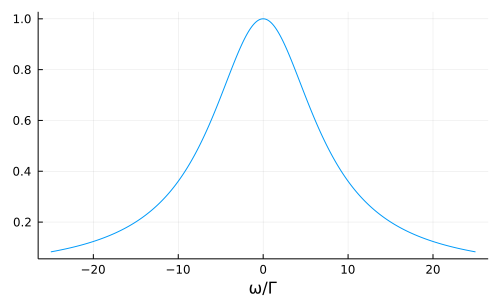

In [18]:
plot(ω, spec_n, xlabel="ω/Γ", legend=false, size=(500,300))